In [1]:
import sqlite3
import pandas as pd
import pandas_ta as ta
import numpy as np
import math

import mplfinance as mpf
import matplotlib.pyplot as plt
import vectorbt as vbt

In [ ]:
# # connect database
# try:
#     # open/create database 
#     database_name = 'setsmart_stock_price.db'
#     con = sqlite3.connect(database_name)
#     cursor = con.cursor()

#     print(f"sqlite: {database_name}")

#     # show all tables
#     cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
#     db_tables = cursor.fetchall()
    
#     print(f"tables: {db_tables}")

#     # read database
#     query_db = '''SELECT * FROM stock_price'''
#     df_stock = pd.read_sql_query(query_db,con)

#     # Convert string to Datetime
#     df_stock['Date'] = pd.to_datetime(df_stock['Date'], format = '%d/%m/%Y')


# except sqlite3.Error as e:
#     print("sqlite >> error: ",e)

In [6]:
# Read CSV
df_stock = pd.read_csv('stock_price_2017_to_Q2-2022.csv')
df_stock['Date'] = pd.to_datetime(df_stock['Date'], format = '%d/%m/%Y')

In [7]:
print(df_stock.dtypes)

Date                  datetime64[ns]
Market                        object
Symbol                        object
Prior                        float64
Open                         float64
High                         float64
Low                          float64
Close                        float64
Change                       float64
%Change                      float64
Average                      float64
AOM Volume                   float64
AOM Value                      int64
TR Volume                    float64
TR Value                     float64
Total Volume                 float64
Total Value                  float64
Market Cap                   float64
PE                           float64
PEG                          float64
PBV                          float64
BVPS                         float64
Dividend Yield               float64
12M Dividend Yield           float64
Volume Turnover              float64
Par                          float64
Listed Share                 float64
d

parameter from: 1 to 100
=========== Optimal Value ===========
parameter optimized: 98
return optimized: -0.296352579642855
Backtest RSI: 98
Backtest Cumulative return: -0.296352579642855


c:\Users\Wisut.K\anaconda3\lib\site-packages\mplfinance\_arg_validators.py:36: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


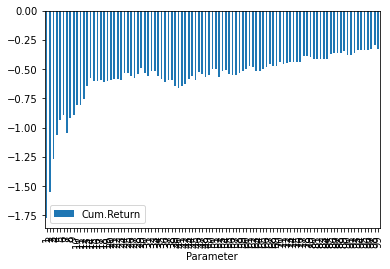

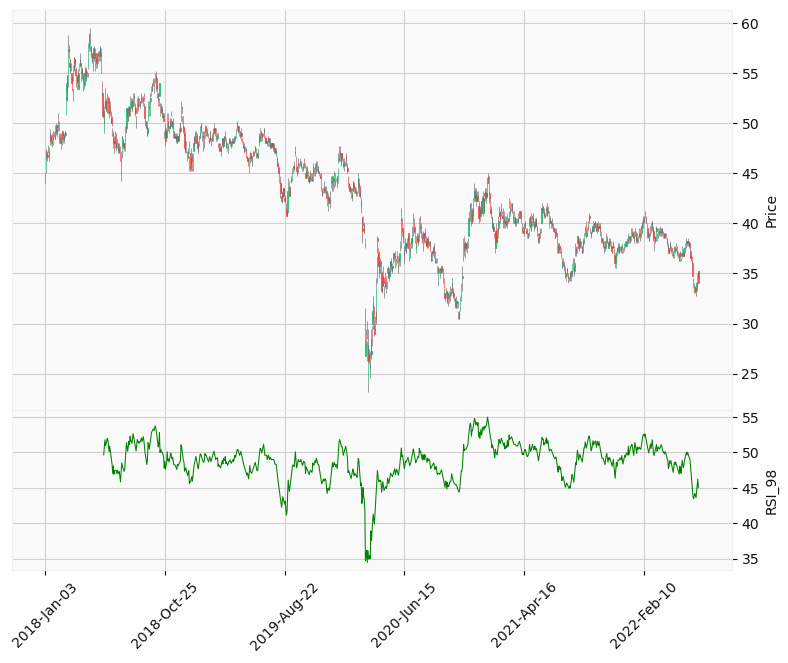

In [8]:
# ========================= Strategy  =========================

# choose stock
symbol = "PTT"              # SET stock symbol

# date range
date_start = "2018-01-01"   # YYYY-MM-DD
date_end = "2022-12-31"     # YYYY-MM-DD

# Signal
rsi_signal = 50

# query historical Price (backtest data)
list_columns = ['Date','Symbol','Prior','Open','High','Low','Close','Total Volume']
df_original = df_stock[list_columns][(df_stock.Symbol == symbol) & (df_stock["Date"] > date_start) & (df_stock["Date"] < date_end)].set_index('Date').rename(columns={"Total Volume": "Volume"}).sort_values(by="Date")

# =================== Strategy Optimization ===================

# parameter constraint
para_optz_start = 1
para_optz_end = 100

# parameter optimization
compare_optz = []

for i in range(para_optz_start,para_optz_end):

    # signal value
    rsi_signal_optz = rsi_signal

    # reset backtest data
    backtest_optz = df_original

    # get action price
    backtest_optz['action_price'] = backtest_optz['Open'].shift(-1)

    # signal calculation (RSI)
    rsi_bar_optz = i
    rsi_optz = backtest_optz.ta.rsi(length=rsi_bar_optz,append=True)

    # create signal
    backtest_optz['signal'] = rsi_optz > rsi_signal_optz

    signal_vectorbt_optz = backtest_optz.ta.tsignals(backtest_optz['signal'], asbool=True, append=True)

    # Create trade reccord
    trades_reccord_optz = backtest_optz.iloc[:,-7:][backtest_optz.TS_Trades !=0]
    trades_reccord_optz['return'] = backtest_optz['action_price'].pct_change()
    trades_reccord_optz = trades_reccord_optz.reset_index().iloc[1::2] 

    # Cumulative return

    cum_return_optz = trades_reccord_optz['return'].sum()

    # Create Trades Summary
    cum_return_optz_i = [(i),cum_return_optz]

    # Save Result
    compare_optz.append(cum_return_optz_i)

result_optz = pd.DataFrame(compare_optz,columns = ['Parameter','Cum.Return'])

result_optimized = result_optz[result_optz['Cum.Return'] == result_optz['Cum.Return'].max()]
para_optimized = int(float(result_optimized['Parameter']))
return_optimized = float(result_optimized['Cum.Return'])

print(f"parameter from: {para_optz_start} to {para_optz_end}")
print('=========== Optimal Value ===========')
print(f"parameter optimized: {para_optimized}")
print(f"return optimized: {return_optimized}")
print('=====================================')

result_optz.set_index('Parameter').plot.bar()

# =================== Strategy Backtesting ====================

# input parameter
rsi_bar = para_optimized

# backtest data
backtest = df_original

# get action price
backtest['action_price'] = backtest['Open'].shift(-1)

# signal calculation (RSI)
rsi_signal_bktest = rsi_signal
rsi_bktest = backtest.ta.rsi(length=rsi_bar,append=True)

# create signal
backtest['signal'] = rsi_bktest > rsi_signal_bktest

signal_vectorbt = backtest.ta.tsignals(backtest['signal'], asbool=True, append=True)

# Create trade reccord
trades_reccord = backtest.iloc[:,-7:][backtest.TS_Trades !=0]
trades_reccord['return'] = backtest['action_price'].pct_change()
trades_reccord = trades_reccord.reset_index().iloc[1::2] 

# Cumulative return
cum_return = trades_reccord['return'].sum()

# display result
print(f"Backtest RSI: {rsi_bar}")
print(f"Backtest Cumulative return: {cum_return}")

### plot:  Price, RSI
rsi_title = 'RSI_' + str(rsi_bar)
apds = mpf.make_addplot(backtest[rsi_title],panel=1,color='g',type='line', width=0.75,ylabel=rsi_title)
mpf.plot(backtest, type='candle', style='yahoo', figsize=(10,8), volume=False,addplot=apds)

### plot: backtest result
port = vbt.Portfolio.from_signals(backtest.Close,
                                  entries = signal_vectorbt.TS_Entries,
                                  exits = signal_vectorbt.TS_Exits,
                                  freq = 'D',
                                  init_cash = 100,
                                  fees = 0.0025,
                                  slippage = 0.0025)
port.plot().show()